In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import preprocessing, linear_model
from sklearn.metrics import mean_squared_error

In [2]:
#Load in data
data = pd.read_csv('data/wrangled_data.csv')

In [3]:
#Reading in data added an extra column
data.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
#This is shifting the Close price to the left, so that I can check for correlation on the next days stocks
y = []
for i in range(len(data)-1):
    y.append(data.Close.iloc[i+1])
    if i % 3270 == 3269:
        y[i] = np.nan
y.append(np.nan)

data['next_close'] = y

#Shifting to the right to get the previous days close
y = []
for i in range(len(data)):
    if i % 3270 == 0:
        y.append(np.nan)
    else:
        y.append(data.Close.iloc[i-1])

data['prev_close'] = y

In [6]:
#Defining return
data['return'] = data['Close'] - data['prev_close']

In [7]:
#Adding a column for the difference in high and low for the day
data['diff_day'] = data['High'] - data['Low']

In [8]:
#Adding a column for difference in 10 day moving average
#and the close price
data['diff_10day'] = data['Close'] - data['tenday_avg']

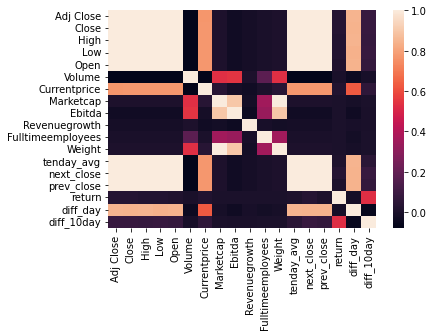

In [9]:
#Visual representation of correlations
sns.heatmap(data.corr())
plt.show()

The High, Low, Open and tenday average are all strongly correlated with the Close price.

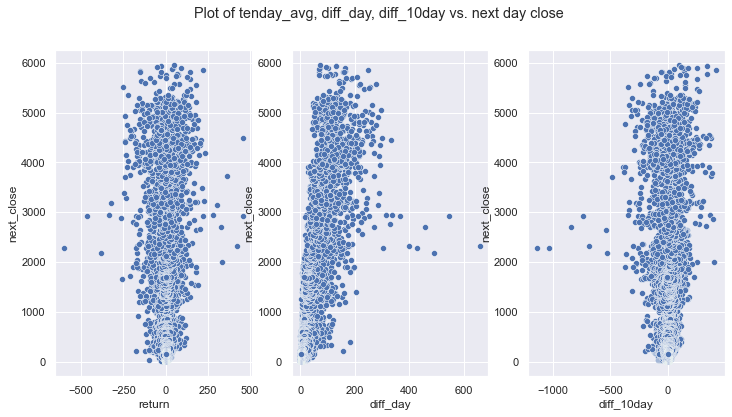

In [10]:
sns.set()
fig, ax = plt.subplots(1,3, figsize=(12, 6))
sns.scatterplot(ax=ax[0], x='return', y='next_close', data=data)
fig.suptitle('Plot of tenday_avg, diff_day, diff_10day vs. next day close')
ax[1] = sns.scatterplot(ax=ax[1], x='diff_day', y='next_close', data=data)
ax[2] = sns.scatterplot(ax=ax[2], x='diff_10day', y='next_close', data=data)
plt.show()

From this plot there is no clear correlation between the return and the next day's close, but there may be a small amount of correlation with the difference in high and low in a day (diff_day). There may be correlation between the difference in stock price and the 10 day moving average with the next day's close price as well. Either of these will probably have high variance. We will use these as indicators.

In [17]:
#Splitting data into train and test.
#We need to drop na values for the model to fit
data_na = data.loc[:, ['return', 'diff_day', 'diff_10day', 'next_close']].dropna()
X = data_na[['return', 'diff_day', 'diff_10day']]
y = data_na['next_close']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
#Scaling X data (will try with and without)
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
scale_X = scaler.transform(X_train)
scaler.fit(X_test)
scale_X_test = scaler.transform(X_test)

In [23]:
rModel = linear_model.LinearRegression()
rModel.fit(X_train ,y_train)

LinearRegression()

In [24]:
y_pred = rModel.predict(X_test)

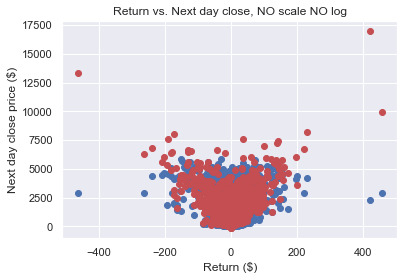

In [33]:
plt.scatter(X_test['return'], y_test, label='Real')
plt.scatter(X_test['return'], y_pred, color='r', label='Real')
plt.xlabel('Return ($)')
plt.ylabel('Next day close price ($)')
plt.title('Return vs. Next day close, NO scale NO log')
plt.legend()
plt.show()

From this graph, it appears as though our model actually does okay between -\\$200 and \\$200, but starts to fail at higher or lower returns.

In [62]:
rModel.score(X_test, y_pred)

-20.879871489022136

In [43]:
mean_squared_error(y_test, y_pred, squared=False)

90.37014122723275

In [46]:
rModel.fit(scale_X, y_train)

LinearRegression()

In [47]:
y_pred_scale = rModel.predict(scale_X_test)

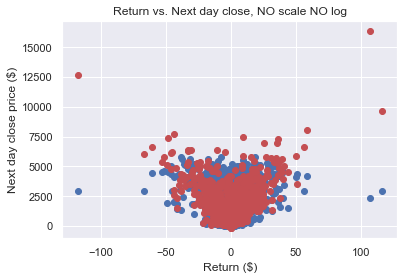

In [57]:
plt.scatter(scale_X_test[:,0], y_test, label='Real')
plt.scatter(scale_X_test[:,0], y_pred_scale, color='r', label='Real')
plt.xlabel('Return ($)')
plt.ylabel('Next day close price ($)')
plt.title('Return vs. Next day close, scale NO log')
plt.legend()
plt.show()

From visual inspection, this graph looks nearly indentical.

In [64]:
rModel.score(scale_X_test, y_test)

0.7146611027315315

In [65]:
mean_squared_error(y_test, y_pred_scale, squared=False)

90.01653683808182

We did end up getting a slightly better RMSE which is good news.

In [77]:
#We will now try a log-linear fit
X_log = np.log(X + abs(np.min(X)) + 1)
X_log_train = np.log(X_train + abs(np.min(X)) + 1)
X_log_test = np.log(X_test + abs(np.min(X)) + 1)

In [78]:
rModel.fit(X_log_train, y_train)

LinearRegression()

In [79]:
y_pred_linlog = rModel.predict(X_log_test)

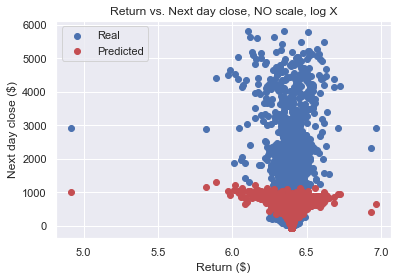

In [83]:
plt.scatter(X_log_test['return'], y_test, label='Real')
plt.scatter(X_log_test['return'], y_pred_linlog, color='r', label='Predicted')
plt.xlabel('Return ($)')
plt.ylabel('Next day close ($)')
plt.title('Return vs. Next day close, NO scale, log X')
plt.legend()
plt.show()

Using the log of X has seemed to make the model perform worse. The best thing to do now is to feature engineer, and hope that more parameters will help to improve the model.

In [82]:
mean_squared_error(y_test, y_pred_linlog, squared=False)

126.14795069603818

In [86]:
#Categorical boolean variable for if it is an up day
data['up'] = data['Close'] > data['prev_close']

In [192]:
#Fraction gained or lost from previous day

data['gain_loss'] = data['return'] / data['prev_close']

In [112]:
#Simple moving averages for 26 and 12 days

sma26 = []
sma12 = []
for i in range(int(len(data))//3270):
    sma26.extend(list(data['Close'].iloc[i*3270:(i+1)*3270].rolling(26).mean()))
    sma12.extend(list(data['Close'].iloc[i*3270:(i+1)*3270].rolling(12).mean()))
    
data['sma12'] = sma12
data['sma26'] = sma26

del sma12, sma26

In [135]:
#Exponential moving average for 12 days

ema12 = []
smoothing = 2
for i in range(len(data)):
    if i % 3270 <= 11:
        ema12.append(np.nan)
    elif i % 3270 == 12:
        ema12.append((data.Close.iloc[i] * (smoothing / 13)) +\
                      (data.sma12.iloc[i-1] * (1 - (smoothing / 13))))
    else:
        ema12.append((data.Close.iloc[i] * (smoothing / 13)) +\
                      (ema12[i-1] * (1 - (smoothing / 13))))

data['ema12'] = ema12

del ema12

In [137]:
#Exponential moving average for 26 days

ema26 = []
smoothing = 2
for i in range(len(data)):
    if i % 3270 <= 25:
        ema26.append(np.nan)
    elif i % 3270 == 26:
        ema26.append((data.Close.iloc[i] * (smoothing / 27)) +\
                      (data.sma12.iloc[i-1] * (1 - (smoothing / 27))))
    else:
        ema26.append((data.Close.iloc[i] * (smoothing / 27)) +\
                      (ema26[i-1] * (1 - (smoothing / 27))))
        
    

data['ema26'] = ema26

del ema26

In [164]:
#Difference in exponential moving averages and close price,
#and creating MACD which is the difference between the two averages.

data['diff_ema12'] = data['Close'] - data['ema12']
data['diff_ema26'] = data['Close'] - data['ema26']
data['macd'] = data['ema12'] - data['ema26']

In [165]:
#Making a 9 day simple moving average of the MACD, only used for the
#EMA of the MACD, known as the signal line.

macd_sma9 = []

for i in range(int(len(data))//3270):
    macd_sma9.extend(list(data['macd'].iloc[i*3270:(i+1)*3270].rolling(9).mean()))

data['macd_sma9'] = macd_sma9

del macd_sma9

In [170]:
#Creating signal line (9 day EMA of MACD)

signal_line = []
smoothing = 2
for i in range(len(data)):
    if i % 3270 <= 34:
        signal_line.append(np.nan)
    elif i % 3270 == 35:
        signal_line.append((data.Close.iloc[i] * (smoothing / 10)) +\
                      (data['macd_sma9'].iloc[i-1] * (1 - (smoothing / 10))))
    else:
        signal_line.append((data.Close.iloc[i] * (smoothing / 10)) +\
                      (signal_line[i-1] * (1 - (smoothing / 10))))
        
data['signal_line'] = signal_line

del signal_line

In [172]:
#Difference from MACD and the signal

data['macd_diff_signal'] = data['macd'] - data['signal_line']

In [173]:
#We have now engineered a few more features for our model to fit.
#We will now create another X array that includes our new features.
data_na = data.loc[:, ['return', 'gain_loss', 'macd', 'macd_diff_signal', \
                  'diff_day', 'diff_10day', 'diff_ema12', 'diff_ema26', 'next_close']].dropna()

X = data_na.loc[:,['return', 'gain_loss', 'macd', 'macd_diff_signal', \
                  'diff_day', 'diff_10day', 'diff_ema12', 'diff_ema26']]
y = data_na['next_close']

In [175]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [176]:
rModel.fit(X_train, y_train)
y_pred = rModel.predict(X_test)

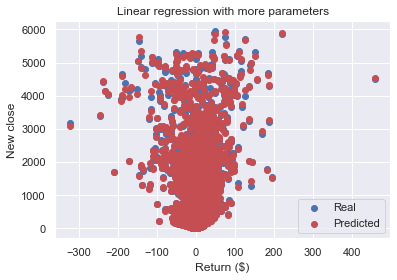

In [181]:
plt.scatter(X_test['return'], y_test, label='Real')
plt.scatter(X_test['return'], y_pred, color='r', label='Predicted')
plt.xlabel('Return ($)')
plt.ylabel('New close ($)')
plt.title('Linear regression with more parameters')
plt.legend(loc='lower right')
plt.show()

It seems as though engineering did a lot for the model. Now that the model has less error, it may be useful to do cross validation and examine the coefficients to determine which parameters were the most useful.

In [182]:
#Looking at coefficients

rModel.coef_

array([ 0.06491564, -1.42491155,  0.24478075, -1.001544  , -0.0361945 ,
       -0.00770958,  0.3153998 ,  0.56018055])

From the coefficients it appears that the return, the difference between the high and low of a day, and the difference between the simple 10 day moving average and the close price are not strong predictors for the closing price of the next day.

In [183]:
rModel.score(X_test, y_test)

0.9994885370645638

In [187]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [188]:
cross_val_score(rModel, X, y, cv=kf)

array([0.99948523, 0.99944311, 0.99938278, 0.99939313, 0.9994484 ])

These cross validation scores are really high, which is a good sign, but they seem too good to be true.